In [1]:
import pandas as pd
filepath = '../dat/data.csv'
data = pd.read_csv(filepath) 

In [2]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
data['offer'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [8]:
import numpy as np
col         = 'offer'
conditions  = [ data[col] == 'Buy One Get One', (data[col] == 'No Offer') , (data[col] == 'Discount') ]
choices     = [ 1, 0, 1 ]
    
data["treatment_tag"] = np.select(conditions, choices, default=np.nan)

In [9]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,treatment_tag
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,1.0
1,6,329.08,1,1,Rural,1,Web,No Offer,0,0.0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,1.0
3,9,675.83,1,0,Rural,1,Web,Discount,0,1.0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,1.0


In [29]:
df  = data.drop_duplicates()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57397 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        57397 non-null  int64  
 1   history        57397 non-null  float64
 2   used_discount  57397 non-null  int64  
 3   used_bogo      57397 non-null  int64  
 4   zip_code       57397 non-null  object 
 5   is_referral    57397 non-null  int64  
 6   channel        57397 non-null  object 
 7   offer          57397 non-null  object 
 8   conversion     57397 non-null  int64  
 9   treatment_tag  57397 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 4.8+ MB


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [32]:
numeric_features = ['recency', 'history']
scaler = MinMaxScaler()
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())])

In [39]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['zip_code', 'channel']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [40]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [41]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LogisticRegression())]
)

In [42]:
X, y = df.drop(columns=['offer','conversion','treatment_tag']), df['conversion']

In [43]:
X.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web
3,9,675.83,1,0,Rural,1,Web
4,2,45.34,1,0,Urban,0,Web


In [44]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: conversion, dtype: int64

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['recency', 'history']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['zip_code', 'channel'])])),
                ('model', LogisticRegression())])

In [47]:
print("model score: %.3f" % model.score(X_test, y_test))

model score: 0.841


In [68]:
from sklearn.preprocessing import MinMaxScaler

numeric_features = ['recency', 'history','used_discount', 'used_bogo']
X_train_num = X_train[numeric_features]
X_test_num = X_test[numeric_features]

In [69]:
scaler = MinMaxScaler()
train_norm = scaler.fit_transform(X_train_num ) 
test_norm = scaler.fit_transform(X_test_num ) 

In [70]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['zip_code', 'channel']
X_train_cat =X_train[categorical_features]
X_test_cat =X_test[categorical_features]

In [71]:
train_ohe = OneHotEncoder(handle_unknown='ignore',sparse = False).fit_transform(X_train_cat)
test_ohe =  OneHotEncoder(handle_unknown='ignore',sparse = False).fit_transform(X_test_cat )

In [72]:
import numpy as np
X_train_2 = np.hstack([train_norm, train_ohe])
X_test_2 = np.hstack([test_norm, test_ohe])

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
gbt_model = GradientBoostingClassifier()
gbt_model.fit(X_train_2, y_train)
gbt_pred = gbt_model.predict(X_test_2)



In [76]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

In [77]:
print("accuracy:", accuracy(y_test, gbt_pred ))
print("precision:", precision(y_test, gbt_pred ))
print("recall:", recall(y_test, gbt_pred ))
print("f1 score:", f1_score(y_test, gbt_pred ))
print("confusion matrix:")
print(confusion_matrix(y_test, gbt_pred ))

accuracy: 0.8411149825783972
precision: 0.0
recall: 0.0
f1 score: 0.0
confusion matrix:
[[9656    1]
 [1823    0]]


In [74]:
import shap
# Fits the explainer

explainer = shap.Explainer(gbt_model, X_test_2)
# alculates the SHAP values - It takes some time
shap_values = explainer(X_test_2)

 94%|=================== | 10827/11480 [00:11<00:00]       

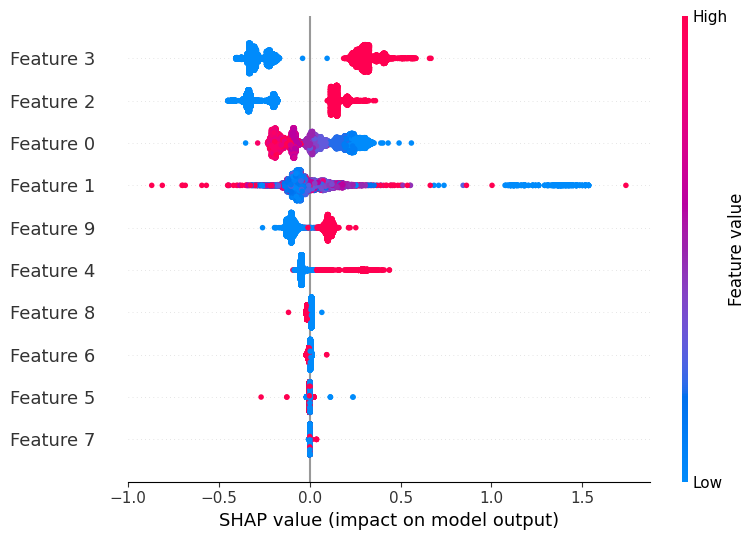

In [78]:
shap.summary_plot(shap_values, X_test_2)


In [79]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklift.models import SoloModel, TwoModels
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from xgboost import XGBClassifier